In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from math import comb  # Combinations
from itertools import combinations

from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from utils.ae_torch_classes import *
from utils.LSTM_gesture_classifier import *

In [2]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

In [3]:
print("Loading")

# Kai's laptop
data_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\saved_datasets\\"
model_dir_path = 'C:\\Users\\kdmen\\Desktop\\Research\\Repos\\fl-gestures\\models\\Embedding\\Autoencoders\\'
metadata_cols_df = pd.read_pickle('C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\saved_datasets\\metadata_cols_df.pkl')
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"
#model_dir_path = 'C:\\Users\\YamagamiLab\\Desktop\\Dev\\fl-gestures\\models\\Embedding\\Autoencoders\\'
#metadata_cols_df = pd.read_pickle('D:\\Kai_MetaGestureClustering_24\\saved_datasets\\metadata_cols_df.pkl')


emg_dir = "filtered_datasets\\EMG_PPD\\"
both_dir = "filtered_datasets\\Both_PPD\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

emg_training_users_df = pd.read_pickle(data_path+emg_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
emg_test_users_df = pd.read_pickle(data_path+emg_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)

both_training_users_df = pd.read_pickle(data_path+both_dir+'training_users_df.pkl').drop(metadata_cols, axis=1)
both_test_users_df = pd.read_pickle(data_path+both_dir+'test_users_df.pkl').drop(metadata_cols, axis=1)


Loading


In [4]:
num_rows_per_gesture = 64 # From the interp
batch_size = 32

## Train/test Split
> Train set:

        - Full dataset XOR all testsets
> Test sets:

        - Last 2 trials of all gestures
        - Hold out 5 users

In [5]:
combined_emg_df = pd.concat([metadata_cols_df, pd.concat([emg_training_users_df, emg_test_users_df])], axis=1)

print(combined_emg_df.shape)
combined_emg_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [6]:
unique_gestures = combined_emg_df['Gesture_ID'].unique()
unique_gestures

array(['pan', 'duplicate', 'zoom-out', 'zoom-in', 'move', 'rotate',
       'select-single', 'delete', 'close', 'open'], dtype=object)

Held Out Users Test Set

In [7]:
held_out_users_lst = ['P104', 'P108', 'P112', 'P116', 'P122', 'P124']
num_test_users = len(held_out_users_lst)
num_train_users = len(combined_emg_df['Participant'].unique()) - num_test_users
heldoutusers_testset = combined_emg_df[combined_emg_df['Participant'].isin(held_out_users_lst)].reset_index(drop=True)

print(heldoutusers_testset.shape)
heldoutusers_testset.head()

(38400, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P104,duplicate,1,-0.836866,-0.069462,-1.201111,-3.266425,-0.143297,-0.012325,-0.246586,-0.874835,-0.903565,-0.139702,-1.199692,-1.301382,-0.065817,-0.008174,-0.002584,-0.011676
1,P104,duplicate,1,-0.780875,-0.082351,-1.208023,-3.258212,-0.110423,0.003053,-0.248364,-1.083834,-0.897283,-0.124933,-1.195211,-1.293138,0.006040,0.004724,0.019656,-0.012380
2,P104,duplicate,1,-0.830069,-0.081989,-1.250259,-3.157837,-0.129984,0.019836,-0.245799,-1.099313,-0.811197,-0.097231,-1.089515,-1.219655,-0.024191,0.015596,-0.015494,0.036700
3,P104,duplicate,1,-0.913201,-0.070693,-1.233590,-2.898543,-0.208200,0.010882,-0.219394,-1.123904,-0.798595,-0.105790,-0.904317,-1.281031,-0.068723,0.011252,-0.005082,0.080905
4,P104,duplicate,1,-0.808832,-0.066996,-1.088678,-2.514705,-0.155542,0.002881,-0.109496,-0.220264,-0.821522,-0.105144,-0.440872,-1.288635,-0.060873,-0.015651,0.004653,0.041557


Last 2 Trials Test Set

In [8]:
import random

def generate_non_repetitive_numbers(n):
    # Generate a list of unique random numbers from 1 to 10
    numbers = random.sample(range(1, 11), n)
    numbers_as_strings_lst = [str(num) for num in numbers]
    return numbers_as_strings_lst

sample_size = 9
held_out_trials_lst = generate_non_repetitive_numbers(sample_size)
print(held_out_trials_lst)

['10', '8', '7', '1', '2', '9', '3', '4', '5']


In [9]:
# Should I be choosing random numbers? 9 and 10 are later so may be different from earlier trials...
# Let's try 4 and 7 instead...
#held_out_trials_lst = ['4', '7']
# ^ SWITCHED TO RANDOM SAMPLES ABOVE! 

num_train_trials = 10 - len(held_out_trials_lst)

heldouttrials_testset = combined_emg_df[combined_emg_df['Gesture_Num'].isin(held_out_trials_lst)].reset_index(drop=True)

print(heldouttrials_testset.shape)
heldouttrials_testset.head()

(184320, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


Remove test users from held out trials (dont double dip test sets...)

In [10]:
heldouttrials_testset

# Drop rows where 'Participant' is in participants_to_drop
heldouttrials_testset = heldouttrials_testset[~heldouttrials_testset['Participant'].isin(held_out_users_lst)].reset_index(drop=True)

print(heldouttrials_testset.shape)
heldouttrials_testset.head()

(149760, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


Make train set now!

In [11]:
# Concatenate the smaller dataframes
combined_testsets = pd.concat([heldouttrials_testset, heldoutusers_testset]).drop_duplicates()

# Perform the anti-join
result_df = combined_emg_df.merge(combined_testsets, on=['Participant', 'Gesture_ID', 'Gesture_Num', 'EMG1', 'EMG2', 'EMG3',
                                                   'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG9', 'EMG10', 'EMG11',
                                                   'EMG12', 'EMG13', 'EMG14', 'EMG15', 'EMG16'],
                           how='left', indicator=True)
trainset = result_df[result_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# Display the result
print(trainset.shape)
trainset.head()

(16640, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
320,P102,pan,6,-0.666966,-0.633952,-0.475173,-0.352233,-0.243259,-0.601183,-0.285339,-0.121635,-0.676986,-1.698196,0.529728,-0.050988,-0.230330,-0.402846,-0.060342,0.003911
321,P102,pan,6,-0.635949,-0.709038,-0.532272,-0.330495,-0.225394,-0.497189,-0.203657,-0.123964,-0.613518,-1.071781,0.000412,-0.193315,0.017167,0.483679,-0.141864,0.008590
322,P102,pan,6,-0.556251,-0.716080,-0.566169,-0.410612,-0.242278,-0.523546,-0.135298,-0.087330,-0.652297,0.048005,-0.026199,-0.996777,0.043741,0.298805,0.127002,0.001701
323,P102,pan,6,-0.586469,-0.745566,-0.524795,-0.404002,-0.275906,-0.629024,-0.261952,-0.117321,-0.758685,-0.091207,-0.045896,-0.354958,-0.141844,-0.727350,0.116163,0.000686
324,P102,pan,6,-0.656221,-0.758517,-0.518906,-0.354410,-0.277196,-0.637006,-0.343533,-0.115195,-0.820082,-1.516063,-0.022433,-0.207511,-0.208542,-0.770115,-0.071771,0.009869


In [12]:
trainset_metadata = trainset.iloc[::num_rows_per_gesture, :3]

print(trainset_metadata.shape)
trainset_metadata.head()

(260, 3)


,Participant,Gesture_ID,Gesture_Num
320,P102,pan,6
960,P102,duplicate,6
1600,P102,zoom-out,6
2240,P102,zoom-in,6
2880,P102,move,6


Encode the labels

In [13]:
# THESE ARE LABELS BY GESTURE!

label_encoder = LabelEncoder()
label_encoder.fit(unique_gestures)

# Transform the gesture labels in each dataset
train_labels = label_encoder.transform(trainset['Gesture_ID'].iloc[::num_rows_per_gesture])
testHOT_labels = label_encoder.transform(heldouttrials_testset['Gesture_ID'].iloc[::num_rows_per_gesture])
testHOU_labels = label_encoder.transform(heldoutusers_testset['Gesture_ID'].iloc[::num_rows_per_gesture])

print(f"train_labels shape: {train_labels.shape}")
print(f"testHOT_labels shape: {testHOT_labels.shape}")
print(f"testHOU_labels shape: {testHOU_labels.shape}")


train_labels shape: (260,)
testHOT_labels shape: (2340,)
testHOU_labels shape: (600,)


In [14]:
# CREATE THE TRAINING SET
num_train_gestures = len(trainset) // num_rows_per_gesture
num_emg_features = emg_training_users_df.shape[1]
num_HOT_gestures = len(heldouttrials_testset) // num_rows_per_gesture
num_HOU_gestures = len(heldoutusers_testset) // num_rows_per_gesture

print(num_train_gestures)
print(num_HOT_gestures)
print(num_HOU_gestures)

260
2340
600


In [15]:
X_3DTensor_full_emg = torch.tensor(trainset.iloc[:,3:].to_numpy().reshape(num_train_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)
Xtest_3DTensor_HOT = torch.tensor(heldouttrials_testset.iloc[:,3:].to_numpy().reshape(num_HOT_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)
Xtest_3DTensor_HOU = torch.tensor(heldoutusers_testset.iloc[:,3:].to_numpy().reshape(num_HOU_gestures, num_rows_per_gesture, num_emg_features), dtype=torch.float32)


In [16]:
hidden_dim_lst = [9]
input_dim = 16
RNNAE_9mir_EMGFull = RNNAutoencoder(input_dim, hidden_dim_lst, num_layers=None, seq_len=num_rows_per_gesture, progressive=False, mirror=True)
RNNAE_9mir_EMGFull.load_state_dict(torch.load(model_dir_path+'RNNAE_9mir_vallossp277_EMGFull.pth'))

<All keys matched successfully>

These are the input data embeddings

In [17]:
X_emg_train_embeddings = RNNAE_9mir_EMGFull.encode(X_3DTensor_full_emg)
X_emgHOT_test_embeddings = RNNAE_9mir_EMGFull.encode(Xtest_3DTensor_HOT)
X_emgHOU_test_embeddings = RNNAE_9mir_EMGFull.encode(Xtest_3DTensor_HOU)

print(f"X_emg_train_embeddings shape: {X_emg_train_embeddings.shape}")
print(f"X_emgHOT_test_embeddings shape: {X_emgHOT_test_embeddings.shape}")
print(f"X_emgHOU_test_embeddings shape: {X_emgHOU_test_embeddings.shape}")


X_emg_train_embeddings shape: torch.Size([260, 64, 9])
X_emgHOT_test_embeddings shape: torch.Size([2340, 64, 9])
X_emgHOU_test_embeddings shape: torch.Size([600, 64, 9])


In [18]:
num_train_gestures_per_user = X_emg_train_embeddings.shape[0]//num_train_users
num_HOT_gestures_per_user = X_emgHOT_test_embeddings.shape[0]//num_train_users
num_HOU_gestures_per_user = X_emgHOU_test_embeddings.shape[0]//num_test_users

print(num_train_gestures_per_user)
print(num_HOT_gestures_per_user)
print(num_HOU_gestures_per_user)

10
90
100


- Each participant has their our HOT dataset and label set
- All participants share and test on the same HOU dataset and label set (these users are necessarily held out of the trianing user set to begin with)

In [19]:
ptrain_3D_dict = dict()
ptest_HOT3D_dict = dict()

ptrain_2D_dict = dict()
ptest_HOT2D_dict = dict()

ptrain_labels_dict = dict()
ptest_labelsHOT_dict = dict()

for p_idx, pID in enumerate(trainset_metadata['Participant'].unique()):
    lb = int(p_idx*num_train_gestures_per_user)
    ub = int(p_idx*num_train_gestures_per_user+num_train_gestures_per_user)
    HOT_lb = int(p_idx*num_HOT_gestures_per_user)
    HOT_ub = int(p_idx*num_HOT_gestures_per_user+num_HOT_gestures_per_user)
    #print(f"pID: {pID}; lb: {lb}; ub: {ub}; HOT_lb: {HOT_lb}; HOT_lb: {HOT_lb}.")
    
    ptrain_3D_dict[pID] = X_emg_train_embeddings[lb:ub, :, :]
    ptest_HOT3D_dict[pID] = X_emgHOT_test_embeddings[HOT_lb:HOT_ub, :, :]

    ptrain_2D_dict[pID] = X_emg_train_embeddings[lb:ub, :, :].reshape(num_train_gestures_per_user, -1).detach().numpy()
    ptest_HOT2D_dict[pID] = X_emgHOT_test_embeddings[HOT_lb:HOT_ub, :, :].reshape(num_HOT_gestures_per_user, -1).detach().numpy()

    ptrain_labels_dict[pID] = train_labels[lb:ub]
    ptest_labelsHOT_dict[pID] = testHOT_labels[HOT_lb:HOT_ub]


In [21]:
using_pytorch=False
k=1  # Change this to k_range in the future...
model_str='KNN'

########################################

participants = list(trainset_metadata['Participant'].unique())
num_participants = len(participants)
triplet_model_HOTaccuracies_matrix = np.zeros((num_participants, num_participants, num_participants))
triplet_model_HOUaccuracies_matrix = np.zeros((num_participants, num_participants, num_participants))
triplet_model_AVGaccuracies_matrix = np.zeros((num_participants, num_participants, num_participants))

# Iterate through every triplet of participants
total_num_combos = comb(num_participants, 3)

if using_pytorch:
    testHOU_dataset = TensorDataset(X_emgHOU_test_embeddings, torch.tensor(testHOU_labels, dtype=torch.float32))
    testHOU_loader = DataLoader(testHOU_dataset, batch_size=batch_size, shuffle=False)
else:
    Xtest_HOU = X_emgHOU_test_embeddings.reshape(X_emgHOU_test_embeddings.shape[0], -1).detach().numpy()
    ytest_HOU = testHOU_labels.reshape(-1, 1)  # Make it 2D...
    
for current_combo_idx, (p1, p2, p3) in enumerate(combinations(participants, 3)):
    if current_combo_idx%100==0:
        print(f"Triplet {current_combo_idx+1} of {total_num_combos}: ({p1}, {p2}, {p3})")
    p1_idx = participants.index(p1)
    p2_idx = participants.index(p2)
    p3_idx = participants.index(p3)

    indices = [(p1_idx, p2_idx, p3_idx), (p1_idx, p3_idx, p2_idx),
               (p2_idx, p1_idx, p3_idx), (p2_idx, p3_idx, p1_idx),
               (p3_idx, p1_idx, p2_idx), (p3_idx, p2_idx, p1_idx)]

    if using_pytorch:
        # Create TensorDataset
        # NEED TO ADD LABELS!!!
        # NEED TO CORRECT pID TO p1 and p2 AND THEN CAT THE TENSORS!
        #torch.cat((tensor1, tensor2), dim=0)
        train_dataset = TensorDataset(ptrain_3D_dict[pID], torch.tensor(ptrain_labels_dict[pID], dtype=torch.float32))
        testHOT_dataset = TensorDataset( ptest_HOT3D_dict[pID], torch.tensor(ptest_labelsHOT_dict[pID], dtype=torch.float32))
        
        # Create DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        testHOT_loader = DataLoader(testHOT_dataset, batch_size=batch_size, shuffle=False)

        # LSTM / NN code note added yet...
    
    else:
        Xtrain = np.concatenate((ptrain_2D_dict[p1], ptrain_2D_dict[p2], ptrain_2D_dict[p3]), axis=0)
        Xtest_HOT = np.concatenate((ptest_HOT2D_dict[p1], ptest_HOT2D_dict[p2], ptest_HOT2D_dict[p3]), axis=0)
        
        ytrain = np.concatenate((ptrain_labels_dict[p1].reshape(-1, 1), ptrain_labels_dict[p2].reshape(-1, 1), ptrain_labels_dict[p3].reshape(-1, 1)), axis=0)  # Make it 2D...
        ytest_HOT = np.concatenate((ptest_labelsHOT_dict[p1].reshape(-1, 1), ptest_labelsHOT_dict[p2].reshape(-1, 1), ptest_labelsHOT_dict[p3].reshape(-1, 1)), axis=0)  # Make it 2D...

        if model_str.upper()=='KNN':
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(Xtrain, ytrain)
            
            y_pred = knn.predict(Xtest_HOT)
            HOT_accuracy = accuracy_score(ytest_HOT, y_pred)

            y_pred = knn.predict(Xtest_HOU)
            HOU_accuracy = accuracy_score(ytest_HOU, y_pred)

            AVG_accuracy = (HOT_accuracy + HOU_accuracy) / 2
        elif model_str.upper()=='SVC':
            svc = SVC(kernel='linear')
            svc.fit(Xtrain, ytrain)
            
            y_pred_HOT = svc.predict(Xtest_HOT)
            HOT_accuracy = accuracy_score(ytest_HOT, y_pred_HOT)
            
            y_pred_HOU = svc.predict(Xtest_HOU)
            HOU_accuracy = accuracy_score(ytest_HOU, y_pred_HOU)
            
            AVG_accuracy = (HOT_accuracy + HOU_accuracy) / 2
        else:
            raise ValueError(f"model_str {model_str} is not supported")

        for idx_triplet in indices:
            triplet_model_HOTaccuracies_matrix[idx_triplet] = HOT_accuracy
            triplet_model_HOUaccuracies_matrix[idx_triplet] = HOU_accuracy
            triplet_model_AVGaccuracies_matrix[idx_triplet] = AVG_accuracy
    


Triplet 1 of 2600: (P102, P103, P105)
Triplet 101 of 2600: (P102, P109, P127)
Triplet 201 of 2600: (P102, P119, P128)
Triplet 301 of 2600: (P103, P105, P106)
Triplet 401 of 2600: (P103, P110, P005)
Triplet 501 of 2600: (P103, P123, P127)
Triplet 601 of 2600: (P105, P107, P111)
Triplet 701 of 2600: (P105, P115, P128)
Triplet 801 of 2600: (P105, P128, P011)
Triplet 901 of 2600: (P106, P111, P132)
Triplet 1001 of 2600: (P106, P125, P005)
Triplet 1101 of 2600: (P107, P111, P115)
Triplet 1201 of 2600: (P107, P123, P006)
Triplet 1301 of 2600: (P109, P111, P132)
Triplet 1401 of 2600: (P109, P125, P005)
Triplet 1501 of 2600: (P110, P115, P126)
Triplet 1601 of 2600: (P110, P128, P008)
Triplet 1701 of 2600: (P111, P121, P004)
Triplet 1801 of 2600: (P114, P118, P119)
Triplet 1901 of 2600: (P114, P132, P005)
Triplet 2001 of 2600: (P115, P127, P006)
Triplet 2101 of 2600: (P118, P127, P128)
Triplet 2201 of 2600: (P119, P128, P131)
Triplet 2301 of 2600: (P121, P004, P006)
Triplet 2401 of 2600: (P125,

In [22]:
import numpy as np
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

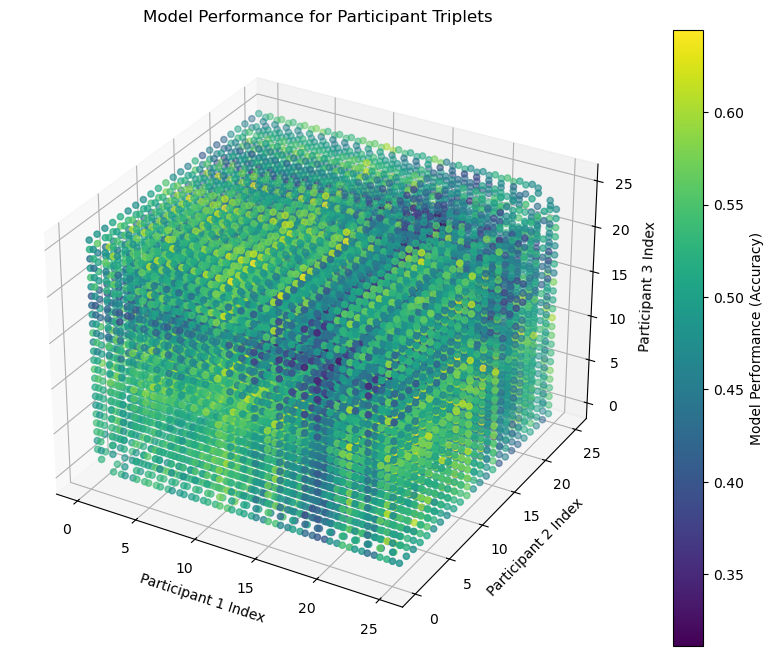

In [23]:
# Prepare data for 3D plot
x = []
y = []
z = []
acc = []

for i in range(num_participants):
    for j in range(num_participants):
        for k in range(num_participants):
            if i != j and j != k and i != k:
                x.append(i)
                y.append(j)
                z.append(k)
                acc.append(triplet_model_HOTaccuracies_matrix[i, j, k])
                #triplet_model_HOTaccuracies_matrix
                #triplet_model_HOUaccuracies_matrix
                #triplet_model_AVGaccuracies_matrix

# Convert lists to numpy arrays
x = np.array(x)
y = np.array(y)
z = np.array(z)
acc = np.array(acc)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x, y, z, c=acc, cmap='viridis', marker='o')

# Add color bar which maps values to colors
cbar = plt.colorbar(sc)
cbar.set_label('Model Performance (Accuracy)')

# Set labels
ax.set_xlabel('Participant 1 Index')
ax.set_ylabel('Participant 2 Index')
ax.set_zlabel('Participant 3 Index')
ax.set_title('Model Performance for Participant Triplets')

plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOTaccuracies_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOTaccuracies_matrix, metric='correlation', cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOTaccuracies_matrix, metric='cosine', cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOUaccuracies_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOUaccuracies_matrix, metric='correlation', cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 8))
sns.clustermap(pairwise_model_HOUaccuracies_matrix, metric='cosine', cmap='viridis', annot=True, fmt=".2f", xticklabels=participants, yticklabels=participants)
plt.xlabel('Participants')
plt.ylabel('Participants')
plt.title('Pairwise Model Accuracies')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
